In [24]:
import pandas as pd
import numpy as np
import pickle
import argparse
import sys
import os
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, auc


### Following is code from RF_deploy.py

In [22]:
def gene_checker(input_file, classifier_genes):
    '''
    Function checks the input file's genes.
    The intersection between the input file's genes and the predetermined classifier genes is taken.
    Then the function checks for genes are not present in the input file.
    For those genes, the expression vector is set to 0.
    A new dataframe is returned with the correct order of genes.

    Parameters
    ----------
    input_file; pandas df - shape should be (samples x genes)
    
    Returns
    ---------
    new_input_file; pandas df - shape (samples x genes)
    '''
    
    new_input_file = input_file.T.loc[classifier_genes].T # seleting classifier selected genes in the classifier determined order
    
    # will fill genes that do not exist in the input with zero
    # if no NAN values, none will be filled
    new_input_file = new_input_file.fillna(0) 
    
    return new_input_file

def deploy(input_file, rf_model=None, model_path=None):

    expr_input = input_file
    classifier_genes = np.loadtxt('../data_test/ClassifierGenes.txt', dtype='str')
        
    print('reading input...')
    if isinstance(input_file, pd.DataFrame):
        expr_input = input_file
    else:
        expr_input = pd.read_csv(expr_input, sep='\t', index_col=0)

    print("before gene intersection...")
    print(expr_input.shape)
    expr_input = gene_checker(expr_input, classifier_genes) # making sure genes are correct for classifier
    print("After gene intersection...")
    print(expr_input.shape)
    
    if model_path is not None:
        print('applying model...')
        model = pickle.load(open(model_path, 'rb'))
        #print(model)
    if rf_model is not None:
        print('applying model...')
        model = rf_model
        #print(model)
    
    predictions = model.predict(expr_input)
    predict_proba = model.predict_proba(expr_input)
    
    print("saving results...")
    predictions = pd.DataFrame(np.hstack([predictions.reshape(-1,1), predict_proba]), index=expr_input.index, columns=['Ribo', 'Proba_0', 'Proba_1'])

    return predictions

## Applying **balanced** model on openPBTA RiboD samples

In [30]:
print('reading input')
input_file = pd.read_csv("../data_test/pbta-gene-expression-rsem-tpm.stranded.csv", sep='\t', index_col=0)

reading input


In [ ]:

models_dir = '/mnt/github/RiboVsPolyA/models/'
auc_list = []
acc_list = []
mean_precision_list = []
for depth in np.arange(1,9):
    print('testing max_depth %d'%depth)
    model_path = models_dir+"RiboVsPoly_balanced_max_depth_%d.sav"%depth
    
    balanced_predictions = deploy(input_file, model_path=model_path)
    res = balanced_predictions.Ribo.value_counts().loc[1.0]/balanced_predictions.shape[0]
    acc_list += [res]
    print('Percentage of RiboD samples correctly classified %.3f'%res)
    
    y_proba = balanced_predictions.Proba_1.values
    precision, recall, _ = precision_recall_curve(np.array(input_file.shape[0]*[1]), y_proba.flatten(), pos_label=1)
    mean_precision = average_precision_score(np.array(input_file.shape[0]*[1]), y_proba.flatten(), pos_label=1)
    mean_precision_list += [mean_precision]
    balanced_auc = auc(recall, precision)
    
    auc_list += [ balanced_auc]
plt.plot(acc_list)
plt.ylabel('% of Samples Correctly Classified')
plt.xlabel('Max Depth')
plt.title("OpenPBTA RiboD Classification across max depth")
plt.xticks(ticks=np.arange(0,8), labels=map(lambda x:str(x), np.arange(1,9)))
plt.show()
plt.close()

In [43]:
balanced_predictions = deploy(input_file, model_path='/mnt/github/RiboVsPolyA/models/RiboVsPoly_balanced_max_depth_1.sav')

reading input...
before gene intersection...
(970, 58347)
After gene intersection...
(970, 5000)
applying model...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


saving results...


In [44]:
# Only two sample was predicted to by RiboD
balanced_predictions.Ribo.value_counts()

1.0    963
0.0      7
Name: Ribo, dtype: int64

In [45]:
res = balanced_predictions.Ribo.value_counts().loc[1.0]/balanced_predictions.shape[0]
print('Percentage of RiboD samples correctly classified %.3f'%res)

Percentage of RiboD samples correctly classified 0.993


## Applying **unbalanced** model on openPBTA RiboD samples

In [50]:
unbalanced_predictions = deploy(input_file, model_path="../models/RiboVsPoly_unbalanced.sav")


reading input...
before gene intersection...
(970, 58347)
After gene intersection...
(970, 5000)
applying model...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=550,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


saving results...


In [51]:
# Only two sample was predicted to by RiboD
unbalanced_predictions.Ribo.value_counts()

1.0    970
Name: Ribo, dtype: int64

In [52]:
res = unbalanced_predictions.Ribo.value_counts().loc[1.0]/unbalanced_predictions.shape[0]
print('Percentage of RiboD samples correctly classified %.3f'%res)

Percentage of RiboD samples correctly classified 1.000


## The majority of sample were wrongly classified as RiboD
* Only 13 samples were correctly classified

## Unbalanced model performs much better than balanced model in RiboD prediction

In [54]:
unbalanced_predictions.shape

(970, 3)

Text(0.5, 1.0, 'Unbalanced Model on RiboD PBTA')

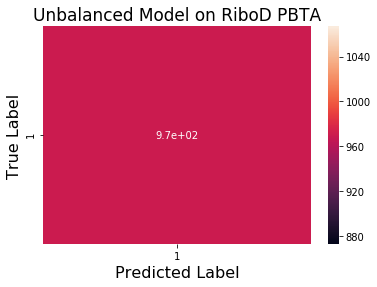

In [77]:
true_labels = unbalanced_predictions.shape[0]*[1]
pred_labels = unbalanced_predictions.Ribo.values

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#plt.figure(figsize=(10,7))
mat = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(mat, annot=True)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(ticks=[0.5], labels=[1])
plt.yticks(ticks=[0.5], labels=[1])

ax.set_title("Unbalanced Model on RiboD PBTA", fontsize=17)